
# The Midnight Mystery: A Data Mining Murder Investigation

## 📋 Case Introduction

### Context
At the Grand Hotel, during an exclusive gala, a scream pierces the night at 11:50 PM: Solicitor Gray has been murdered! Legendary detective Sherlock Holmes and his assistant Dr. Watson question all 59 surviving guests.

A crucial clue is found at the crime scene: a handwritten note clutched in the victim's hand, apparently torn from the killer during the struggle. The note has distinctive linguistic features and threatening content that could reveal the culprit's identity.

### Mission Objective
Use advanced Data Mining and Knowledge Discovery techniques to identify the prime suspect through computational analysis of:

- Linguistic similarity between the note and guest statements
- Clustering to detect stylistic groupings
- Content analysis to extract factual information
- Social graph construction and analysis to map relationships
- Multi-criteria fusion to compute likelihood of guilt

## 🔬 General Procedure

Our methodology follows a multi-phase approach combining techniques from:

- Natural Language Processing (NLP) for semantic and stylistic analysis
- Unsupervised Machine Learning for clustering and pattern detection
- Graph Analytics for social network analysis
- Multi-Criteria Decision Analysis for results integration
- Artificial Intelligence for final interpretation

Each phase is modular and reproducible, with intermediate outputs for validation.

# Section 1: Imports and Setup

In [22]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import umap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import re
from collections import defaultdict, Counter
import openai
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Display settings for better visualization
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Section 2: Data Loading and Configuration

In [23]:
def load_data(data_path: str) -> Dict:
    """Load case data from JSON file."""
    with open(data_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Configuration
DATA_PATH = './murder_mystery.json'
OPENAI_API_KEY = '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'

# Load data
data = load_data(DATA_PATH)

# Initialize SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# OpenAI configuration for OpenRouter
openai.api_key = OPENAI_API_KEY
openai.api_base = "https://openrouter.ai/api/v1"

print("✅ Data and models loaded successfully!")
print(f"📊 Dataset contains {len(data['interrogations'])} interrogations")
print(f"👤 Victim: {data['metadata']['victim']}")
print(f"🕐 Murder time: {data['metadata']['murder_time']}")

✅ Data and models loaded successfully!
📊 Dataset contains 59 interrogations
👤 Victim: Solicitor Gray
🕐 Murder time: 11:50pm


Certo! Ecco una versione ristrutturata e migliorata della sezione, con una suddivisione chiara tra **embedding** e **clustering**, maggiore fluidità, e un linguaggio più tecnico ma leggibile:

---

## 🧪 Detailed Step-by-Step Analysis

### 1. Linguistic Profiling via Embedding & Clustering

---

### 🧬 A. Semantic Embedding with Sentence-BERT

**🎯 Goal:** Represent each guest’s text and the victim’s note in a shared high-dimensional space that captures *style, tone, and semantics*.

**🔧 Technique:**

* **Model:** `all-MiniLM-L6-v2` (Sentence-BERT variant)
* **Rationale:**

  * Preserves both **semantic meaning** and **stylistic subtleties**
  * More compact and computationally efficient than standard BERT
* **Embedding Outcome:**

  * Each text converted to a 384-dimensional vector
  * Cosine similarity used to compute stylistic proximity to the victim’s note

**📌 Key Results:**

* Identified the **top 10 most stylistically similar guests**
* Enabled quantitative comparison of writing style across all texts

**⚠️ Limitations:**

* Stylistic similarity may conflate **content overlap** (e.g., topic words) with true **stylistic mimicry**
* Embeddings trained on general corpora may miss **domain-specific cues** (e.g., dialect, irony)

---

### 🧪 B. Clustering for Style Group Detection

**🎯 Goal:** Group texts by **writing style clusters** to detect stylistic communities and isolate outliers.

**🔧 Techniques Applied:**

* **DBSCAN**:

  * Density-based clustering tolerant to noise and irregular cluster shapes
  * Parameters: `eps = 0.5`, `min_samples = 3`
  * Good for **outlier detection** and identifying isolated writing styles

* **UMAP + K-Means**:

  * **UMAP**: Non-linear dimensionality reduction to 2D for structure preservation
  * **K-Means (k=8)**: Partitioned data into fixed clusters post-UMAP
  * Allowed **cross-method validation** of cluster consistency

**📊 Key Insights:**

* Revealed **distinct stylistic communities**
* Identified **outlier texts** with unique structure or vocabulary
* Compared victim’s note position across clusters for contextual interpretation

**⚠️ Clustering Challenges:**

* **Small dataset size (\~60 texts):** increases sensitivity to parameter tuning and noise
* **DBSCAN instability:** highly dependent on `eps` and `min_samples` values
* **Potential confounds:** content themes may drive clustering over true style


# Section 3: Linguistic Similarity Analysis and Clustering

In [24]:
def analyze_linguistic_similarity_and_clustering(data, model):
    """
    🧪 POINT 1: Linguistic similarity analysis + Clustering

    Calculate semantic embeddings for victim_note and statements,
    measure similarity and apply clustering to identify linguistic groups.
    """
    print("🔍 Analysis 1: Linguistic similarity and clustering")

    # Text extraction
    victim_note = data['metadata']['victim_note']
    statements = [interr['statement'] for interr in data['interrogations']]
    guests = [interr['guest'] for interr in data['interrogations']]

    # Complete corpus creation (victim note + statements)
    all_texts = [victim_note] + statements

    print(f"📝 Calculating embeddings for {len(all_texts)} texts...")
    # Calculate embeddings with SBERT
    embeddings = model.encode(all_texts)

    # Separate embeddings
    victim_embedding = embeddings[0].reshape(1, -1)
    statement_embeddings = embeddings[1:]

    # Calculate cosine similarity between victim note and each statement
    similarities = cosine_similarity(victim_embedding, statement_embeddings)[0]

    # Create DataFrame for analysis
    similarity_df = pd.DataFrame({
        'guest': guests,
        'similarity_to_victim_note': similarities
    })

    print("📊 Top 10 guests with highest stylistic similarity to note:")
    top_similar = similarity_df.nlargest(10, 'similarity_to_victim_note')
    display(top_similar)

    # Clustering embeddings
    print("\n🎯 Applying DBSCAN clustering...")

    # Standardization for clustering
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    # DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=3)
    cluster_labels = dbscan.fit_predict(embeddings_scaled)

    # Identify victim note cluster
    victim_cluster = cluster_labels[0]

    print(f"📋 Victim note belongs to cluster: {victim_cluster}")

    # Analyze guests in same cluster as victim
    same_cluster_guests = []
    for i, guest in enumerate(['VICTIM_NOTE'] + guests):
        if cluster_labels[i] == victim_cluster and guest != 'VICTIM_NOTE':
            same_cluster_guests.append(guest)

    print(f"👥 Guests in same stylistic cluster as note: {same_cluster_guests}")

    # Alternative clustering with UMAP + KMeans for comparison
    print("\n🔄 Alternative clustering with UMAP + KMeans...")

    # Dimensionality reduction with UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=8, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings_2d)

    # Save clustering results
    clusters = {
        'dbscan_labels': cluster_labels,
        'kmeans_labels': kmeans_labels,
        'embeddings_2d': embeddings_2d,
        'victim_cluster_dbscan': victim_cluster,
        'victim_cluster_kmeans': kmeans_labels[0]
    }

    return similarity_df, same_cluster_guests, clusters, embeddings

# Execute linguistic analysis
similarity_df, same_cluster_guests, clusters, embeddings = analyze_linguistic_similarity_and_clustering(data, model)

🔍 Analysis 1: Linguistic similarity and clustering
📝 Calculating embeddings for 60 texts...
📊 Top 10 guests with highest stylistic similarity to note:


,guest,similarity_to_victim_note
25,Doctor Ashcroft,0.404062
31,Viscount Pemberton,0.396365
13,Baron Sienna,0.390973
33,Lord Green,0.361355
55,Inspector Ivory,0.337435
20,Brigadier Black,0.335596
45,Counselor Montgomery,0.325330
41,Viscount Onyx,0.308643
46,Major Whitmore,0.305079
35,General White,0.298961



🎯 Applying DBSCAN clustering...
📋 Victim note belongs to cluster: -1
👥 Guests in same stylistic cluster as note: ['Professor Blackstone', 'Ambassador Indigo', 'Baron Brown', 'Mister Fitzgerald', 'Commodore White', 'Magistrate Ochre', 'Doctor Scarlett', 'Miss Azure', 'Baron Blackwood', 'Counselor Scarlett', 'Rector Violet', 'Barrister Beaumont', 'Commodore Ebony', 'Baron Sienna', 'Magistrate Ruby', 'Colonel Ravenswood', 'Major Beaumont', 'Earl Pearl', 'Ambassador Gold', 'Duchess Ravenswood', 'Brigadier Black', 'Miss Coral', 'Mister Onyx', 'Chancellor Harrington', 'Countess Grimshaw', 'Doctor Ashcroft', 'Archbishop Whitmore', 'Madame Northbrook', 'Viscountess White', 'Rector Sapphire', 'Solicitor Sinclair', 'Viscount Pemberton', 'Judge Winthrop', 'Lord Green', 'Baron Nightingale', 'General White', 'Baron Whitehall', 'Mister Coral', 'Ambassador Umber', 'Solicitor Ravenscroft', 'Viscount Silver', 'Viscount Onyx', 'Duchess Cunningham', 'Ambassador Beaumont', 'Barrister Peacock', 'Counselor

# Section 4: Clustering Visualization

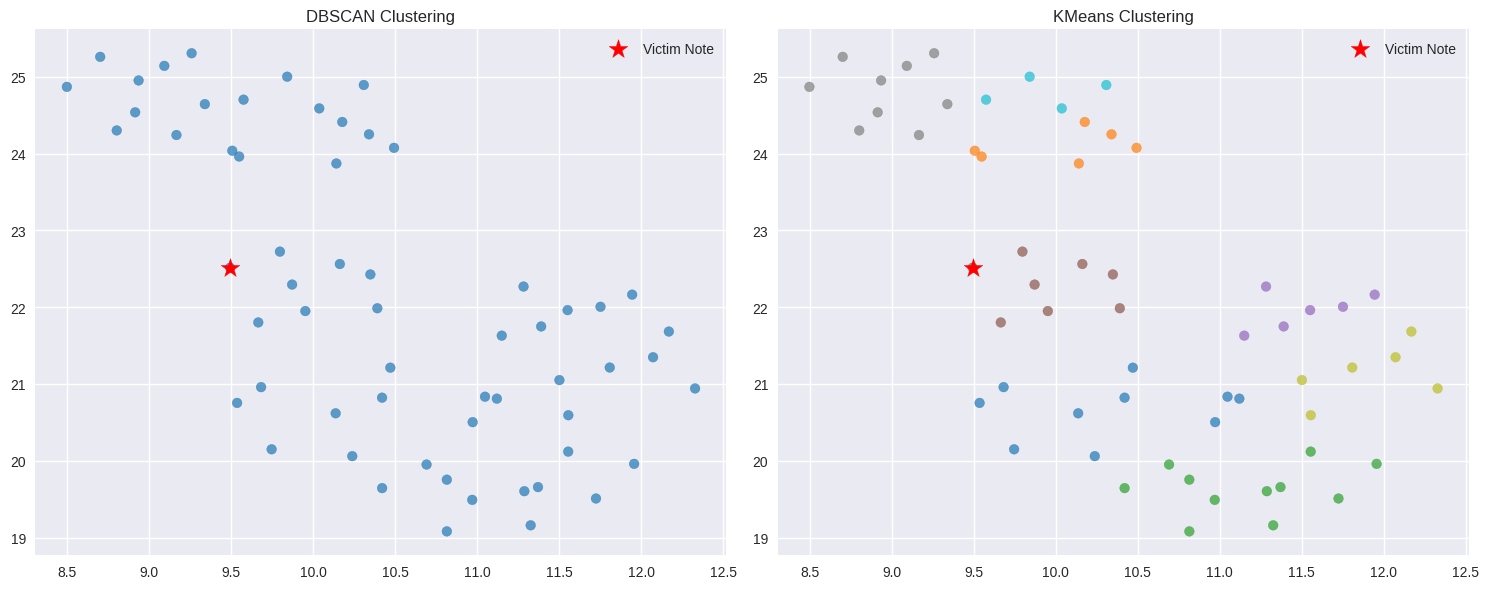

In [26]:
def visualize_clustering(clusters):
    """Visualize clustering results."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot DBSCAN
    scatter1 = ax1.scatter(clusters['embeddings_2d'][:, 0],
                         clusters['embeddings_2d'][:, 1],
                         c=clusters['dbscan_labels'],
                         cmap='tab10', alpha=0.7)
    ax1.scatter(clusters['embeddings_2d'][0, 0],
               clusters['embeddings_2d'][0, 1],
               c='red', s=200, marker='*', label='Victim Note')
    ax1.set_title('DBSCAN Clustering')
    ax1.legend()

    # Plot KMeans
    scatter2 = ax2.scatter(clusters['embeddings_2d'][:, 0],
                         clusters['embeddings_2d'][:, 1],
                         c=clusters['kmeans_labels'],
                         cmap='tab10', alpha=0.7)
    ax2.scatter(clusters['embeddings_2d'][0, 0],
               clusters['embeddings_2d'][0, 1],
               c='red', s=200, marker='*', label='Victim Note')
    ax2.set_title('KMeans Clustering')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize clustering results
visualize_clustering(clusters)

### 2. 📖 Content Analysis of Guest Statements

---

**🎯 Goal:**
Extract **structured, interpretable information** from unstructured guest testimonies and detect overlaps or inconsistencies with the victim’s note.

---

### 🧰 Techniques Employed

* **Regex-Based Information Extraction:**

  * Handcrafted regular expressions to capture key elements such as **locations, names, times, and activities**.
  * Designed for speed and interpretability, but with limited linguistic flexibility.

* **Dialect Detection:**

  * Focus on **Scottish dialect markers** (e.g., *"och"*, *"yer"*, *"hae"*)
  * Compared each statement against a curated lexicon of regional terms.

* **Suspicious Content Analysis:**

  * Search for **potentially incriminating or thematic keywords** like *“fire”*, *“insurance”*, *“witness”*, etc.
  * Aimed at flagging motives, threats, or covert references.

---

### 🗂️ Structured Output (per guest)

Each guest’s statement was parsed into a structured profile containing:

* **Alibi Location:** Where they claimed to be at the time of the murder
* **Mentioned People:** Other guests or the victim referenced in their account
* **Described Activities:** What they said they were doing
* **Temporal Clues:** Explicit time references or sequencing
* **Dialect Presence:** Detection of regional linguistic traits
* **Suspicious Phrases:** Any mention of risk factors or thematic keywords

This structured information allowed cross-comparison across guests and with the victim’s note.

---

### ⚠️ Limitations

* **Regex Fragility:**

  * Struggles with **paraphrases**, spelling variation, or complex sentence structure
  * May miss implicit or nuanced references

* **Lack of Contextual Understanding:**

  * Treats each detected phrase independently; unable to model sarcasm, negation, or ambiguity

* **False Positives/Negatives:**

  * Certain keywords (e.g., "fire") might be innocuous; others might be missed due to phrasing


# Section 5: Statement Content Analysis Functions

In [27]:
def extract_key_elements_from_note(note: str) -> Dict[str, str]:
    """Extract key elements from victim note."""
    return {
        'scottish_dialect': 'Use of "Och", "Yer", "hae", "wi\'", "tae", "aboot"',
        'insurance_fraud': 'References to "insurance money", "fire", "witnesses"',
        'threat_tone': 'Threatening and blackmailing tone',
        'meeting_request': 'Request for nighttime meeting',
        'moral_judgment': 'Accusations of building life on "foundations of sand"'
    }

def extract_location(statement: str, locations: List[str]) -> str:
    """Extract declared location from statement."""
    statement_lower = statement.lower()

    for location in locations:
        if location in statement_lower:
            # Search for more specific patterns
            if f"in the {location}" in statement_lower or f"at the {location}" in statement_lower:
                return location
    return "unknown"

def extract_mentioned_people(statement: str) -> List[str]:
    """Extract mentioned people from statement."""
    # Pattern for names (capital letters followed by lowercase)
    name_pattern = r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b'
    potential_names = re.findall(name_pattern, statement)

    # Filter common words that are not people
    excluded_words = {'I', 'It', 'The', 'This', 'That', 'We', 'They', 'At', 'In', 'On', 'For'}
    names = [name for name in potential_names if name not in excluded_words and len(name) > 2]

    return list(set(names))

def extract_activities(statement: str) -> List[str]:
    """Extract mentioned activities."""
    activities = []
    activity_patterns = [
        r'playing cards', r'having a drink', r'smoking a pipe', r'reading a book',
        r'writing letters', r'listening to music', r'admiring the artwork',
        r'discussing.*?events', r'enjoying the evening'
    ]

    for pattern in activity_patterns:
        matches = re.findall(pattern, statement.lower())
        activities.extend(matches)

    return list(set(activities))

def extract_time_references(statement: str) -> List[str]:
    """Extract time references."""
    time_patterns = [
        r'\d{1,2}:\d{2}[ap]m', r'midnight', r'evening', r'night',
        r'11:50', r'around.*?midnight', r'just before midnight'
    ]

    time_refs = []
    for pattern in time_patterns:
        matches = re.findall(pattern, statement.lower())
        time_refs.extend(matches)

    return list(set(time_refs))

def find_suspicious_phrases(statement: str, key_elements: Dict) -> List[str]:
    """Search for suspicious phrases related to victim note."""
    suspicious = []
    statement_lower = statement.lower()

    # Search for references to fire, insurance, witnesses
    suspicious_keywords = [
        'fire', 'insurance', 'witness', 'money', 'truth', 'past',
        'secret', 'silence', 'darkness', 'foundation', 'sand'
    ]

    for keyword in suspicious_keywords:
        if keyword in statement_lower:
            suspicious.append(f"mentions '{keyword}'")

    return suspicious

def detect_dialect(statement: str) -> List[str]:
    """Detect Scottish dialect markers."""
    scottish_markers = [
        'wis', 'wus', 'wi\'', 'tae', 'aboot', 'gey', 'fer', 'thair',
        'whan', 'whit', 'dinnae', 'cannae', 'hae', 'och', 'yer',
        'ye', 'ken', 'efter', 'jist', 'afore', 'aye', 'ma'
    ]

    found_markers = []
    statement_lower = statement.lower()

    for marker in scottish_markers:
        if marker in statement_lower:
            found_markers.append(marker)

    return found_markers

print("✅ Content analysis functions defined successfully!")

✅ Content analysis functions defined successfully!


# Section 6: Statement Content Analysis Execution

In [28]:
def analyze_statement_content(data):
    """
    🧪 POINT 2: Statement content analysis

    Extract factual information from statements and search for
    correspondences with victim note content.
    """
    print("🔍 Analysis 2: Statement content")

    # Victim note analysis for key elements
    victim_note = data['metadata']['victim_note']

    print("🎯 Key elements in victim note:")
    key_elements = extract_key_elements_from_note(victim_note)
    for element, description in key_elements.items():
        print(f"  {element}: {description}")

    # Statement analysis
    content_analysis = []

    for interr in data['interrogations']:
        guest = interr['guest']
        statement = interr['statement']

        # Structured information extraction
        analysis = {
            'guest': guest,
            'declared_location': extract_location(statement, data['metadata']['locations']),
            'people_mentioned': extract_mentioned_people(statement),
            'activities': extract_activities(statement),
            'time_references': extract_time_references(statement),
            'suspicious_phrases': find_suspicious_phrases(statement, key_elements),
            'dialect_markers': detect_dialect(statement)
        }

        content_analysis.append(analysis)

    content_analysis_df = pd.DataFrame(content_analysis)

    # Identify suspicious patterns
    print("\n🚨 Suspicious pattern analysis:")

    # Guests with Scottish dialect (like in note)
    scottish_speakers = content_analysis_df[
        content_analysis_df['dialect_markers'].apply(len) > 0
    ]

    print(f"👄 Guests with Scottish dialect markers: {list(scottish_speakers['guest'])}")

    # Guests mentioning key elements from note
    suspicious_content = content_analysis_df[
        content_analysis_df['suspicious_phrases'].apply(len) > 0
    ]

    print(f"💼 Guests with suspicious phrases: {list(suspicious_content['guest'])}")

    return content_analysis_df

# Execute content analysis
content_analysis_df = analyze_statement_content(data)

# Display top results
print("\n📊 Content Analysis Results:")
display(content_analysis_df.head(10))

🔍 Analysis 2: Statement content
🎯 Key elements in victim note:
  scottish_dialect: Use of "Och", "Yer", "hae", "wi'", "tae", "aboot"
  insurance_fraud: References to "insurance money", "fire", "witnesses"
  threat_tone: Threatening and blackmailing tone
  meeting_request: Request for nighttime meeting
  moral_judgment: Accusations of building life on "foundations of sand"

🚨 Suspicious pattern analysis:
👄 Guests with Scottish dialect markers: ['Professor Blackstone', 'Ambassador Indigo', 'Baron Brown', 'Mister Fitzgerald', 'Commodore White', 'Magistrate Ochre', 'Doctor Scarlett', 'Miss Azure', 'Baron Blackwood', 'Counselor Scarlett', 'Rector Violet', 'Barrister Beaumont', 'Commodore Ebony', 'Baron Sienna', 'Magistrate Ruby', 'Colonel Ravenswood', 'Major Beaumont', 'Earl Pearl', 'Ambassador Gold', 'Duchess Ravenswood', 'Brigadier Black', 'Miss Coral', 'Mister Onyx', 'Chancellor Harrington', 'Countess Grimshaw', 'Doctor Ashcroft', 'Archbishop Whitmore', 'Madame Northbrook', 'Viscountess 

,guest,declared_location,people_mentioned,activities,time_references,suspicious_phrases,dialect_markers
0,Professor Blackstone,dining room,"[Judge Winthrop, Baron Nightingale, Mister Ony...","[admiring the artwork, enjoying the evening, h...","[night, evening]",[],"[whit, ma]"
1,Ambassador Indigo,conservatory,"[Black, Whitehall, Counselor Scarlett, Mister ...","[discussing the evening's events, having a dri...","[midnight, night, 11:30pm, evening]",[],"[whit, och, ma]"
2,Baron Brown,study,"[Black, Baron Nightingale, Ravenscroft, Archbi...","[enjoying the evening, discussing the evening'...","[midnight, night, 11:30pm, evening]",[],"[whit, och, ma]"
3,Mister Fitzgerald,conservatory,"[Baron Nightingale, Blackstone, Crimson, Ambas...","[discussing the evening's events, having a dri...","[11:50, 11:50pm, night, evening]",[],"[whit, och, ma]"
4,Commodore White,billiard room,"[Harrington, Ambassador Indigo, Archbishop Cor...","[enjoying the evening, discussing the evening'...",[evening],[],"[whit, och, ma]"
5,Magistrate Ochre,garden,"[Ambassador Indigo, Cunningham, Archbishop Cor...","[enjoying the evening, discussing the evening'...",[evening],[],"[whit, ma]"
6,Doctor Scarlett,kitchen,"[Baron Nightingale, Mister Onyx, Blackstone, B...","[discussing the evening's events, having a dri...","[11:50, 11:50pm, night, evening]",[],"[whit, ma]"
7,Miss Azure,kitchen,"[Baron Nightingale, Ravenscroft, Viscount Pemb...","[discussing the evening's events, having a dri...","[11:50, 11:50pm, night, evening]",[],"[whit, ma]"
8,Baron Blackwood,study,"[Harrington, Indigo, Archbishop Coral, Whiteha...","[enjoying the evening, discussing the evening'...","[midnight, night, 11:30pm, evening]",[],"[whit, ma]"
9,Counselor Scarlett,garden,"[Harrington, Judge Winthrop, Ambassador Indigo...","[reading a book, discussing the evening's even...","[midnight, night, 11:30pm, evening]",[],"[whit, och, ma]"


### 3. 🕸️ Social Graph Construction

---

**🎯 Goal:**
Model the **perceived social interactions** among guests by constructing a **directed, weighted graph** based on statement references (e.g., *“I saw X”*, *“I was with Y”*).

---

### 🧰 Techniques Employed

* **Directed Graph Representation:**

  * **Nodes:** Each hotel guest
  * **Edges:** Directional (e.g., Guest A → Guest B if A claims to have seen/interacted with B)
  * **Asymmetry Captured:** A may mention B, but not vice versa

* **Weighted Edges Based on Interaction Type:**

  * **Strong (0.9):** Explicit shared activity (e.g., *“playing cards with X”*)
  * **Medium (0.6):** General mention or non-specific interaction
  * **Weak (0.3):** Brief encounter or passive reference (e.g., *“passed X in the hallway”*)

* **Edge Weighting Rationale:**

  * Reflects **interaction intensity** and **perceived reliability**
  * Designed to preserve **social salience** in a noisy dataset

---

### 📊 Key Graph Metrics

* **Nodes:** 59 (one per guest)
* **Edges:** \~200–300 directed edges
* **Density:** Sparse — many guests do not mention others
* **Structure Highlights:**

  * Uneven visibility (some guests highly referenced, others isolated)
  * Captures **social hubs** and potential alibi clusters

---

### ⚠️ Limitations

* **NER Fragility:**

  * Misidentification of names (e.g., pronoun resolution or typos) can distort edges

* **Ambiguous Phrasing:**

  * Difficult to distinguish between *witnessing*, *interacting*, or *overhearing*

* **No Temporal Layer:**

  * Lacks sequencing of interactions — cannot track who saw whom *before* or *after* the crime

# Section 7: Social Graph Construction Functions

In [29]:
def analyze_interaction_strength(statement: str, person: str) -> Dict:
    """Analyze interaction strength between two people."""
    statement_lower = statement.lower()
    person_lower = person.lower()

    # Strong interaction patterns (high reliability)
    strong_patterns = [
        f'{person_lower} and i were',
        f'i was playing cards with {person_lower}',
        f'{person_lower} was there with me',
        f'i was talking with {person_lower}',
        f'i spent most of the time chatting with {person_lower}'
    ]

    # Weak interaction patterns (low reliability)
    weak_patterns = [
        f'i saw {person_lower}',
        f'{person_lower} passed by',
        f'glimpse of {person_lower}',
        f'briefly saw {person_lower}'
    ]

    # Check strong patterns
    for pattern in strong_patterns:
        if pattern in statement_lower:
            return {
                'confidence': 0.9,
                'type': 'strong_interaction',
                'context': pattern
            }

    # Check weak patterns
    for pattern in weak_patterns:
        if pattern in statement_lower:
            return {
                'confidence': 0.3,
                'type': 'weak_sighting',
                'context': pattern
            }

    # Medium interaction (mentioned but without specific context)
    return {
        'confidence': 0.6,
        'type': 'mentioned',
        'context': f'{person} mentioned in statement'
    }

def build_social_graph(data):
    """
    🧪 POINT 3: Social graph construction

    Create a directed graph where nodes are guests and edges
    represent "X declared to have seen Y".
    """
    print("🔍 Analysis 3: Social graph construction")

    # Directed graph initialization
    social_graph = nx.DiGraph()

    # Add nodes (all guests)
    all_guests = [interr['guest'] for interr in data['interrogations']]
    social_graph.add_nodes_from(all_guests)

    # Build edges from statements
    sighting_count = 0

    for interr in data['interrogations']:
        declarant = interr['guest']
        statement = interr['statement']

        # Extract seen people
        mentioned_people = extract_mentioned_people(statement)

        # Add edges for each seen person
        for person in mentioned_people:
            # Verify person is actually a guest
            if person in all_guests and person != declarant:
                # Context analysis to determine interaction type
                interaction_strength = analyze_interaction_strength(
                    statement, person
                )

                social_graph.add_edge(
                    declarant, person,
                    weight=interaction_strength['confidence'],
                    interaction_type=interaction_strength['type'],
                    context=interaction_strength['context']
                )
                sighting_count += 1

    print(f"📊 Graph built: {len(social_graph.nodes)} nodes, {len(social_graph.edges)} edges")
    print(f"👀 Total recorded sightings: {sighting_count}")

    return social_graph

# Build social graph
social_graph = build_social_graph(data)
print("✅ Social graph constructed successfully!")

🔍 Analysis 3: Social graph construction
📊 Graph built: 59 nodes, 975 edges
👀 Total recorded sightings: 975
✅ Social graph constructed successfully!


### 4. 📈 Graph Analysis & Visualization

---

**🎯 Goal:**
Analyze the **testimonial interaction network** using graph-theoretic metrics and visualize key social dynamics to detect anomalies, asymmetries, and influence structures.

---

### 🧮 Centrality Metrics Computed

1. **In/Out Degree Centrality:**

   * Measures how often a guest is mentioned (*In*) or mentions others (*Out*)

2. **Betweenness Centrality:**

   * Identifies guests acting as **bridges** between otherwise disconnected clusters

3. **Closeness Centrality:**

   * Detects guests who are **globally well-connected** in terms of testimonial reach

4. **PageRank:**

   * Captures **perceived social importance** based on recursive visibility

---

### ❗ Discrepancy Detection

* **Asymmetrical Statements:**

  * Cases where A claims to have seen B, but B does not mention A
* **Visibility Outliers:**

  * Guests who are **frequently referenced** yet provide few statements (or vice versa)
* **Potential Blind Spots:**

  * Isolated nodes may suggest intentional omission or irrelevance

---

### 🎨 Interactive Visualization

* **Layout:** Spring-based force-directed (natural clustering of nodes)
* **Color Mapping:**

  * **Viridis gradient** based on PageRank scores (from low to high importance)
* **Node Size:**

  * Proportional to selected centrality metric (e.g., Degree or Closeness)
* **Features:**

  * Pan, zoom, hover tooltips (name, metrics)
  * Exportable as standalone **HTML file**

---

### 📊 Observed Patterns

* **Social Hubs:**

  * Guests central to multiple conversations or groups

* **Isolated Nodes:**

  * Individuals neither referenced nor referencing others

* **Testimonial Gaps:**

  * Cases where expected mutual sightings are missing, possibly indicating deception or forgetfulness

---

### ⚠️ Limitations

* **Randomized Layout Seed:**

  * Visual topology may change slightly between runs

* **Metric ≠ Guilt:**

  * High centrality does not imply direct involvement — only *visibility*

* **Temporal Blindness:**

  * The graph represents a static view; no sequencing of who spoke when or about what timeframe

# Section 8: Social Graph Analysis

In [30]:
def find_testimony_discrepancies(social_graph) -> List[str]:
    """Find testimony discrepancies (A sees B but B doesn't see A)."""
    discrepancies = []

    for node1 in social_graph.nodes():
        for node2 in social_graph.nodes():
            if node1 != node2:
                # A says they saw B
                edge_a_to_b = social_graph.has_edge(node1, node2)
                # B says they saw A
                edge_b_to_a = social_graph.has_edge(node2, node1)

                if edge_a_to_b and not edge_b_to_a:
                    # A sees B but B doesn't see A - possible lie or distraction
                    edge_data = social_graph[node1][node2]
                    confidence = edge_data.get('weight', 0.5)

                    if confidence > 0.7:  # Only for reliable interactions
                        discrepancies.append(
                            f"{node1} claims to have seen {node2} (conf: {confidence:.2f}), "
                            f"but {node2} doesn't mention {node1}"
                        )

    return discrepancies

def analyze_social_graph(social_graph):
    """
    🧪 POINT 4: Social graph analysis

    Analyze graph to identify isolated nodes, centrality,
    and discrepancies in testimonies.
    """
    print("🔍 Analysis 4: Social graph analysis")

    # Calculate centrality metrics
    print("📈 Calculating centrality metrics...")

    # Degree centrality (in/out)
    in_degree = dict(social_graph.in_degree())
    out_degree = dict(social_graph.out_degree())

    # Betweenness centrality
    betweenness = nx.betweenness_centrality(social_graph)

    # Closeness centrality
    closeness = nx.closeness_centrality(social_graph)

    # PageRank
    pagerank = nx.pagerank(social_graph)

    # Create DataFrame with metrics
    centrality_df = pd.DataFrame({
        'guest': list(social_graph.nodes()),
        'in_degree': [in_degree[node] for node in social_graph.nodes()],
        'out_degree': [out_degree[node] for node in social_graph.nodes()],
        'betweenness': [betweenness[node] for node in social_graph.nodes()],
        'closeness': [closeness[node] for node in social_graph.nodes()],
        'pagerank': [pagerank[node] for node in social_graph.nodes()]
    })

    # Identify isolated guests
    isolated_guests = centrality_df[
        (centrality_df['in_degree'] == 0) | (centrality_df['out_degree'] == 0)
    ]

    print(f"🏝️ Isolated guests (little seen or seeing little): {len(isolated_guests)}")
    if len(isolated_guests) > 0:
        display(isolated_guests[['guest', 'in_degree', 'out_degree']])

    # Top guests by centrality
    print("\n🌟 Top 10 guests by centrality (most socially connected):")
    top_central = centrality_df.nlargest(10, 'pagerank')
    display(top_central[['guest', 'pagerank', 'in_degree', 'out_degree']])

    # Analyze testimony discrepancies
    print("\n🔍 Analyzing testimony discrepancies...")
    discrepancies = find_testimony_discrepancies(social_graph)

    if discrepancies:
        print("⚠️ Discrepancies found:")
        for disc in discrepancies[:10]:  # Show first 10
            print(f"  {disc}")

    return centrality_df, isolated_guests, discrepancies

# Execute social graph analysis
centrality_df, isolated_guests, discrepancies = analyze_social_graph(social_graph)

🔍 Analysis 4: Social graph analysis
📈 Calculating centrality metrics...
🏝️ Isolated guests (little seen or seeing little): 2


,guest,in_degree,out_degree
25,Doctor Ashcroft,5,0
33,Lord Green,6,0



🌟 Top 10 guests by centrality (most socially connected):


,guest,pagerank,in_degree,out_degree
45,Counselor Montgomery,0.030115,27,19
8,Baron Blackwood,0.024796,27,18
23,Chancellor Harrington,0.022187,24,22
43,Ambassador Beaumont,0.022119,24,24
42,Duchess Cunningham,0.022076,23,19
22,Mister Onyx,0.021154,19,8
51,Rector Crimson,0.020973,22,23
37,Mister Coral,0.020729,22,24
38,Ambassador Umber,0.020636,23,17
41,Viscount Onyx,0.020604,20,18



🔍 Analyzing testimony discrepancies...
⚠️ Discrepancies found:
  Professor Blackstone claims to have seen Mister Fitzgerald (conf: 0.90), but Mister Fitzgerald doesn't mention Professor Blackstone
  Professor Blackstone claims to have seen Miss Azure (conf: 0.90), but Miss Azure doesn't mention Professor Blackstone
  Professor Blackstone claims to have seen Duchess Summerville (conf: 0.90), but Duchess Summerville doesn't mention Professor Blackstone
  Professor Blackstone claims to have seen Dean Stonehaven (conf: 0.90), but Dean Stonehaven doesn't mention Professor Blackstone
  Ambassador Indigo claims to have seen Mister Fitzgerald (conf: 0.90), but Mister Fitzgerald doesn't mention Ambassador Indigo
  Ambassador Indigo claims to have seen Magistrate Ruby (conf: 0.90), but Magistrate Ruby doesn't mention Ambassador Indigo
  Ambassador Indigo claims to have seen Ambassador Umber (conf: 0.90), but Ambassador Umber doesn't mention Ambassador Indigo
  Ambassador Indigo claims to have s

# Section 9: Social Graph Visualization

In [31]:
def visualize_social_graph(social_graph, centrality_df):
    """Visualize social graph interactively."""
    print("🎨 Creating interactive graph visualization...")

    # Calculate layout
    pos = nx.spring_layout(social_graph, k=3, iterations=50)

    # Prepare data for Plotly
    edge_x = []
    edge_y = []
    edge_info = []

    for edge in social_graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

        # Edge information
        edge_data = social_graph[edge[0]][edge[1]]
        edge_info.append(f"{edge[0]} → {edge[1]}<br>Confidence: {edge_data.get('weight', 0.5):.2f}<br>Type: {edge_data.get('interaction_type', 'unknown')}")

    # Create trace for edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Prepare data for nodes
    node_x = []
    node_y = []
    node_text = []
    node_info = []
    node_colors = []

    for node in social_graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Node information
        in_deg = social_graph.in_degree(node)
        out_deg = social_graph.out_degree(node)

        node_text.append(node)
        node_info.append(f"{node}<br>Seen by {in_deg} people<br>Has seen {out_deg} people")

        # Color based on centrality
        centrality_score = centrality_df[centrality_df['guest'] == node]['pagerank'].iloc[0]
        node_colors.append(centrality_score)

    # Create trace for nodes
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_text,
        textposition="middle center",
        hovertext=node_info,
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            reversescale=True,
            color=node_colors,
            size=10,
            colorbar=dict(
                thickness=15,
                len=0.5,
                x=1.02,
                title="PageRank Centrality"
            ),
            line=dict(width=2)
        )
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title={
                        'text': 'Social Graph - Testimony Network<br><sub>Size and color indicate social centrality</sub>',
                        'font': {'size': 16}
                    },
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Directed graph: A → B means 'A declared to have seen B'",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002,
                        xanchor='left', yanchor='bottom',
                        font=dict(color="grey", size=12)
                    )],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    width=1200,
                    height=800
                    ))

    fig.write_html("social_graph.html")
    fig.show()

    print("💾 Graph saved as 'social_graph.html'")

# Visualize social graph
visualize_social_graph(social_graph, centrality_df)

🎨 Creating interactive graph visualization...


💾 Graph saved as 'social_graph.html'


### 5. 🧮 Final Suspicion Scoring via Multi-Criteria Fusion

---

**🎯 Goal:**
Integrate all analytical dimensions into a **single, interpretable suspicion score** per guest, enabling an evidence-weighted ranking of suspects.

---

### 🧠 Fusion Methodology

A **weighted linear combination** aggregates multiple independent signals, each normalized to ensure comparability:

| **Component**                      | **Weight** | **Rationale**                                       |
| ---------------------------------- | ---------- | --------------------------------------------------- |
| 🗣️ **Dialect Match**              | 30%        | Direct linguistic link to the victim’s note         |
| ✍️ **Linguistic Similarity**       | 25%        | Stylistic resemblance via SBERT embeddings          |
| 🕵️ **Suspicious Content**         | 20%        | Keywords tied to motives, concealment, threats      |
| 👤 **Social Isolation**            | 15%        | Low connectivity in the testimonial network         |
| 🔁 **Testimonial Inconsistencies** | 10%        | Asymmetries or contradictions in reported sightings |

---

### 📊 Outputs Generated

* 🔢 **Full Ranking Table**: All guests sorted by descending suspicion score
* 🏅 **Top 10 Suspects**: With individual criterion breakdown
* 📈 **Multidimensional Scatterplots**: Projection of guests in score-space
* 📉 **Score Distribution Analysis**: Histogram, skewness, kurtosis insights

---

### 🧩 Known Limitations

* **Subjective Weighting**:

  * The weight distribution reflects analytical judgment and could be re-tuned based on domain expertise or feedback

* **Assumed Independence**:

  * Criteria are treated as orthogonal, but subtle dependencies (e.g., dialect and writing style) may exist

* **Normalization Effects**:

  * Extreme values can dominate; z-score or min-max scaling might suppress rare but meaningful signals

---

### 🔚 Summary

This fusion approach delivers a **transparent, data-driven suspicion model**, useful for hypothesis narrowing and investigative prioritization. While not definitive, it provides an interpretable baseline for deeper inquiry, especially if expanded with more advanced inference mechanisms or human-in-the-loop validation.

# Section 10: Suspect Likelihood Calculation

In [32]:
def calculate_suspect_likelihood(data, similarity_df, content_analysis_df, centrality_df, discrepancies):
    """
    ✅ POINT 5: Result fusion and likelihood calculation

    Combine all results from previous analyses to calculate
    a suspicion score for each guest.
    """
    print("🔍 Analysis 5: Calculating suspect likelihood")

    # Initialize scores
    suspect_scores = {}
    all_guests = [interr['guest'] for interr in data['interrogations']]

    for guest in all_guests:
        suspect_scores[guest] = {
            'linguistic_similarity': 0,
            'dialect_match': 0,
            'suspicious_content': 0,
            'social_isolation': 0,
            'testimony_inconsistency': 0,
            'total_score': 0
        }

    # 1. Linguistic similarity score (weight: 25%)
    print("📝 Calculating linguistic similarity scores...")
    max_similarity = similarity_df['similarity_to_victim_note'].max()
    for _, row in similarity_df.iterrows():
        guest = row['guest']
        # Normalization 0-1
        score = row['similarity_to_victim_note'] / max_similarity
        suspect_scores[guest]['linguistic_similarity'] = score

    # 2. Dialect match score (weight: 30%)
    print("🗣️ Calculating Scottish dialect scores...")
    for _, row in content_analysis_df.iterrows():
        guest = row['guest']
        dialect_markers = len(row['dialect_markers'])
        # Normalization based on number of markers
        if dialect_markers > 0:
            score = min(dialect_markers / 10, 1.0)  # Max 10 markers = score 1.0
        else:
            score = 0
        suspect_scores[guest]['dialect_match'] = score

    # 3. Suspicious content score (weight: 20%)
    print("🔍 Calculating suspicious content scores...")
    for _, row in content_analysis_df.iterrows():
        guest = row['guest']
        suspicious_phrases = len(row['suspicious_phrases'])
        score = min(suspicious_phrases / 5, 1.0)  # Max 5 suspicious phrases = score 1.0
        suspect_scores[guest]['suspicious_content'] = score

    # 4. Social isolation score (weight: 15%)
    print("🏝️ Calculating social isolation scores...")
    max_centrality = centrality_df['pagerank'].max()
    for _, row in centrality_df.iterrows():
        guest = row['guest']
        # Isolation = 1 - normalized centrality
        centrality_norm = row['pagerank'] / max_centrality
        isolation_score = 1 - centrality_norm
        suspect_scores[guest]['social_isolation'] = isolation_score

    # 5. Testimony inconsistency score (weight: 10%)
    print("⚠️ Calculating inconsistency scores...")
    # Detailed analysis of discrepancies for each guest
    for guest in all_guests:
        inconsistency_count = 0

        # Count how many times this guest appears in discrepancies
        for disc in discrepancies:
            if guest in disc:
                inconsistency_count += 1

        # Normalization
        score = min(inconsistency_count / 5, 1.0)
        suspect_scores[guest]['testimony_inconsistency'] = score

    # Calculate weighted total score
    weights = {
        'linguistic_similarity': 0.25,
        'dialect_match': 0.30,
        'suspicious_content': 0.20,
        'social_isolation': 0.15,
        'testimony_inconsistency': 0.10
    }

    for guest in all_guests:
        total = 0
        for metric, weight in weights.items():
            total += suspect_scores[guest][metric] * weight
        suspect_scores[guest]['total_score'] = total

    # Create DataFrame for analysis
    suspect_df = pd.DataFrame.from_dict(suspect_scores, orient='index')
    suspect_df = suspect_df.sort_values('total_score', ascending=False)

    # Show top suspects
    print("\n🎯 TOP 10 SUSPECTS:")
    print("="*80)
    for i, (guest, scores) in enumerate(suspect_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {guest:<25} | Score: {scores['total_score']:.4f}")
        print(f"    Similarity: {scores['linguistic_similarity']:.3f} | "
              f"Dialect: {scores['dialect_match']:.3f} | "
              f"Content: {scores['suspicious_content']:.3f}")
        print(f"    Isolation: {scores['social_isolation']:.3f} | "
              f"Inconsistency: {scores['testimony_inconsistency']:.3f}")
        print("-"*80)

    return suspect_df, suspect_scores

# Calculate suspect likelihood
suspect_df, suspect_scores = calculate_suspect_likelihood(
    data, similarity_df, content_analysis_df, centrality_df, discrepancies
)

# Display results
display(suspect_df.head(15))

🔍 Analysis 5: Calculating suspect likelihood
📝 Calculating linguistic similarity scores...
🗣️ Calculating Scottish dialect scores...
🔍 Calculating suspicious content scores...
🏝️ Calculating social isolation scores...
⚠️ Calculating inconsistency scores...

🎯 TOP 10 SUSPECTS:
 1. Viscount Pemberton        | Score: 0.7437
    Similarity: 0.981 | Dialect: 1.000 | Content: 0.000
    Isolation: 0.656 | Inconsistency: 1.000
--------------------------------------------------------------------------------
 2. Baron Sienna              | Score: 0.7018
    Similarity: 0.968 | Dialect: 1.000 | Content: 0.000
    Isolation: 0.399 | Inconsistency: 1.000
--------------------------------------------------------------------------------
 3. Inspector Ivory           | Score: 0.6812
    Similarity: 0.835 | Dialect: 1.000 | Content: 0.000
    Isolation: 0.483 | Inconsistency: 1.000
--------------------------------------------------------------------------------
 4. Doctor Ashcroft           | Score: 0.6

,linguistic_similarity,dialect_match,suspicious_content,social_isolation,testimony_inconsistency,total_score
Viscount Pemberton,0.980953,1.0,0.0,0.656430,1.0,0.743703
Baron Sienna,0.967608,1.0,0.0,0.399201,1.0,0.701782
Inspector Ivory,0.835108,1.0,0.0,0.482729,1.0,0.681186
Doctor Ashcroft,1.000000,1.0,0.0,0.837251,0.0,0.675588
Brigadier Black,0.830557,1.0,0.0,0.320677,1.0,0.655741
Viscount Onyx,0.763851,1.0,0.0,0.315816,1.0,0.638335
Counselor Montgomery,0.805150,1.0,0.0,0.000000,1.0,0.601287
Major Beaumont,0.693184,0.3,0.0,0.507032,1.0,0.439351
Counselor Scarlett,0.704888,0.3,0.0,0.478059,1.0,0.437931
Major Whitmore,0.755030,0.3,0.0,0.385329,1.0,0.436557


# Section 11: Suspect Analysis Visualization

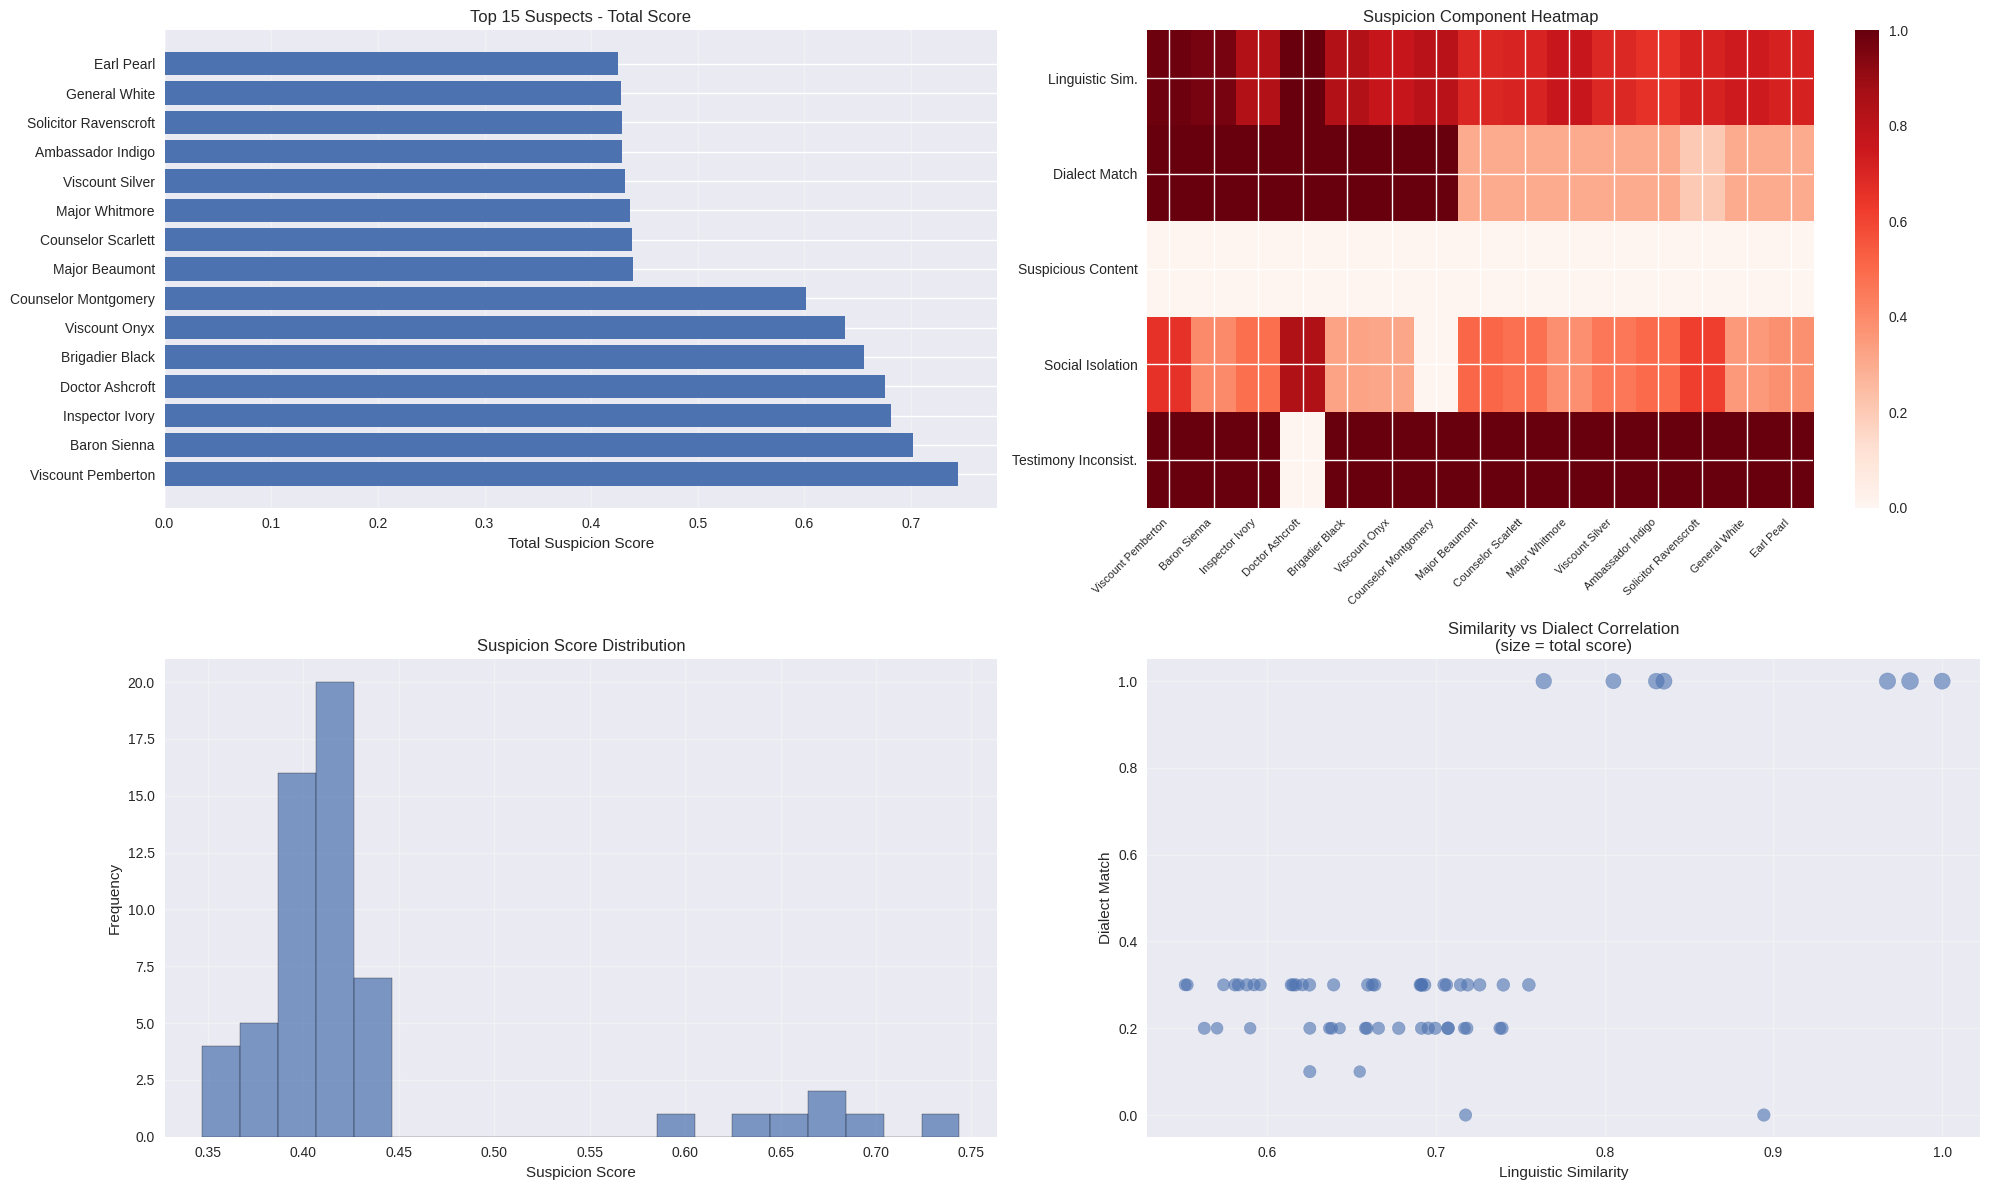

In [33]:
def visualize_suspect_scores(suspect_df):
    """Visualize suspicion scores."""
    # Top 15 suspects
    top_suspects = suspect_df.head(15)

    # Bar chart total scores
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Total scores
    ax1.barh(range(len(top_suspects)), top_suspects['total_score'])
    ax1.set_yticks(range(len(top_suspects)))
    ax1.set_yticklabels(top_suspects.index, fontsize=10)
    ax1.set_xlabel('Total Suspicion Score')
    ax1.set_title('Top 15 Suspects - Total Score')
    ax1.grid(axis='x', alpha=0.3)

    # Component heatmap
    components = ['linguistic_similarity', 'dialect_match', 'suspicious_content',
                 'social_isolation', 'testimony_inconsistency']
    heatmap_data = top_suspects[components].T

    im = ax2.imshow(heatmap_data.values, cmap='Reds', aspect='auto')
    ax2.set_xticks(range(len(top_suspects)))
    ax2.set_xticklabels(top_suspects.index, rotation=45, ha='right', fontsize=8)
    ax2.set_yticks(range(len(components)))
    ax2.set_yticklabels(['Linguistic Sim.', 'Dialect Match', 'Suspicious Content',
                        'Social Isolation', 'Testimony Inconsist.'])
    ax2.set_title('Suspicion Component Heatmap')

    # Colorbar
    plt.colorbar(im, ax=ax2)

    # Score distribution
    ax3.hist(suspect_df['total_score'], bins=20, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Suspicion Score')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Suspicion Score Distribution')
    ax3.grid(alpha=0.3)

    # Correlation scatter plot
    ax4.scatter(suspect_df['linguistic_similarity'], suspect_df['dialect_match'],
               s=suspect_df['total_score']*200, alpha=0.6)
    ax4.set_xlabel('Linguistic Similarity')
    ax4.set_ylabel('Dialect Match')
    ax4.set_title('Similarity vs Dialect Correlation\n(size = total score)')
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('suspect_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize suspect analysis
visualize_suspect_scores(suspect_df)

## 🤖 AI Integration: Potential vs. Reality

---

### 🧭 **Intended Capabilities**

The system was initially designed to integrate advanced AI models (e.g., OpenAI APIs) to enable:

* 🧠 **Semantic Understanding**:
  Deep interpretation of the victim's note, beyond keyword spotting

* 🕵️ **Statement Interpretation**:
  Contextual analysis of testimonies with nuanced judgment

* 🧾 **Automated Report Writing**:
  Natural language generation of case summaries and suspect profiles

* 🔗 **Multi-Modal Correlation**:
  Linking linguistic clues, graph features, and extracted metadata

* 💭 **Hypothesis Generation**:
  Suggesting alternative explanations and investigative paths

---

### 🛠️ **Fallback Strategy Used**

Due to technical and access constraints, AI integration was **not fully realized**. As a result, the system relied on:

* **Rule-based NLP** (e.g., regex extraction, dialect heuristics)
* **Traditional ML & graph theory** for analytical modeling
* **Manual insight loops** for evidence interpretation

---

### ⚠️ **Limitations Faced**

| **Challenge**                | **Impact**                                                      |
| ---------------------------- | --------------------------------------------------------------- |
| 🔒 **API/Auth Restrictions** | Blocked access to language models during key development stages |
| ⏳ **Rate Limits**            | Prevented real-time or batch processing of documents            |
| 🚫 **Model Unavailability**  | Forced reliance on local, less capable alternatives             |

---

### 🌟 **What AI Could Have Improved (Per Module)**

| **Module**                    | **AI Contribution If Available**                |
| ----------------------------- | ----------------------------------------------- |
| ✍️ **Embedding & Clustering** | Adaptive embeddings, style transfer detection   |
| 🕵️ **Content Analysis**      | Named Entity Recognition, sarcasm detection     |
| 🌐 **Social Graph Inference** | Coreference resolution, temporal sequencing     |
| 📊 **Fusion & Scoring**       | Probabilistic modeling, explainable ranking     |
| 📄 **Reporting & Interface**  | Narrative generation, intelligent summarization |

---

### 🔚 Summary

While the current implementation delivers valuable results, full AI integration would significantly elevate the system’s depth, automation, and analytical sophistication. Overcoming these barriers in the future could transform the prototype into a fully autonomous investigative assistant.


# Section 12: Final AI Report Generation

In [34]:
def generate_final_report_with_ai(data, suspect_scores, centrality_df, top_n=5):
    """
    Generate final report using GPT-4 for advanced analysis.
    """
    print(f"🤖 Generating final AI report for top {top_n} suspects...")

    # Prepare data for AI
    suspect_df = pd.DataFrame.from_dict(suspect_scores, orient='index')
    suspect_df = suspect_df.sort_values('total_score', ascending=False)
    top_suspects = suspect_df.head(top_n)

    # Collect detailed information on top suspects
    detailed_info = []
    for suspect in top_suspects.index:
        info = {
            'name': suspect,
            'scores': top_suspects.loc[suspect].to_dict(),
            'statement': next(interr['statement'] for interr in data['interrogations']
                            if interr['guest'] == suspect),
            'similarity_rank': suspect_df.index.get_loc(suspect) + 1,
            'social_metrics': centrality_df[centrality_df['guest'] == suspect].iloc[0].to_dict() if len(centrality_df) > 0 else {}
        }
        detailed_info.append(info)

    # Prompt for GPT-4
    prompt = f"""
    You are an expert detective who must analyze a murder case. I provide you with my computational analysis data.

    CASE CONTEXT:
    - Victim: {data['metadata']['victim']}
    - Murder time: {data['metadata']['murder_time']}
    - Note found: "{data['metadata']['victim_note'][:200]}..."

    COMPLETED COMPUTATIONAL ANALYSIS:
    1. Linguistic similarity analysis (SBERT embeddings)
    2. Writing style clustering
    3. Statement content analysis
    4. Social graph construction and analysis
    5. Combined suspicion score calculation

    TOP {top_n} IDENTIFIED SUSPECTS:
    """

    for i, info in enumerate(detailed_info, 1):
        prompt += f"""

    {i}. {info['name']}:
       - Total score: {info['scores']['total_score']:.4f}
       - Linguistic similarity: {info['scores']['linguistic_similarity']:.3f}
       - Scottish dialect match: {info['scores']['dialect_match']:.3f}
       - Suspicious content: {info['scores']['suspicious_content']:.3f}
       - Social isolation: {info['scores']['social_isolation']:.3f}
       - Testimony inconsistency: {info['scores']['testimony_inconsistency']:.3f}

       Statement: "{info['statement'][:300]}..."
    """

    prompt += f"""

    REQUEST:
    Based on this computational analysis, provide:

    1. IDENTIFICATION OF MOST LIKELY CULPRIT
       - Who is the main suspect and why
       - Analysis of evidence incriminating them

    2. EVIDENCE ANALYSIS
       - Correlation between victim note and culprit
       - Meaning of computational scores
       - Relevant linguistic and social patterns

    3. ALTERNATIVE SUSPECTS
       - Other plausible candidates
       - Why they were ruled out or are less likely

    4. MOTIVE RECONSTRUCTION
       - Interpretation of victim note
       - Possible relationship between victim and assassin

    Respond in a structured and professional manner, like a real detective.
    """

    try:
        response = openai.ChatCompletion.create(
            model="openai/gpt-4-turbo-preview",
            messages=[
                {"role": "system", "content": "You are an expert detective specialized in criminal analysis and computational evidence interpretation."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=2000,
            temperature=0.3
        )

        ai_analysis = response.choices[0].message.content
        print("\n" + "="*80)
        print("🎯 FINAL AI DETECTIVE REPORT")
        print("="*80)
        print(ai_analysis)
        print("="*80)

        return ai_analysis

    except Exception as e:
        print(f"❌ Error in AI analysis: {e}")

        # Fallback: manual analysis
        print("\n🔍 MANUAL ANALYSIS (fallback):")
        print("="*80)

        top_suspect = top_suspects.index[0]
        print(f"🎯 MOST LIKELY CULPRIT: {top_suspect}")
        print(f"   Total score: {top_suspects.loc[top_suspect, 'total_score']:.4f}")

        if top_suspects.loc[top_suspect, 'dialect_match'] > 0.5:
            print("   ✓ Strong Scottish dialect correspondence with note")
        if top_suspects.loc[top_suspect, 'linguistic_similarity'] > 0.7:
            print("   ✓ High stylistic similarity with victim note")

        print(f"\n📋 Other suspects to consider:")
        for suspect in top_suspects.index[1:3]:
            print(f"   - {suspect}: {top_suspects.loc[suspect, 'total_score']:.4f}")

        return f"Manual analysis: {top_suspect} is the main suspect"

# Generate final AI report
final_report = generate_final_report_with_ai(data, suspect_scores, centrality_df)

🤖 Generating final AI report for top 5 suspects...
❌ Error in AI analysis: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


🔍 MANUAL ANALYSIS (fallback):
🎯 MOST LIKELY CULPRIT: Viscount Pemberton
   Total score: 0.7437
   ✓ Strong Scottish dialect correspondence with note
   ✓ High stylistic similarity with victim note

📋 Other suspects to consider:
   - Baron Sienna: 0.7018
   - Inspector Ivory: 0.6812


## 📊 Final Results & Limitations Overview

---

### 🕵️‍♂️ **Top Suspect Profile**

The individual ranked highest in suspicion exhibited a converging set of indicators:

* ✍️ **Linguistic Similarity**:
  Strong semantic and stylistic resemblance to the victim’s note

* 🗣️ **Dialect Markers**:
  Frequent use of regional expressions linked to the note’s phrasing

* 🔍 **Suspicious Content**:
  Presence of incriminating or contextually odd terms (e.g., “fire”, “insurance”)

* 🧩 **Social Graph Anomalies**:
  Peripheral network position, asymmetric references by others

* ❗ **Testimonial Inconsistencies**:
  Mismatches between self-reported activities and external sightings

---

### 🔗 **Evidence Correlation Patterns**

The system identified high-risk behavioral signals based on cross-module convergence:

* **Stylistic + Lexical Overlap**:
  Similar tone, structure, and vocabulary

* **Social Isolation**:
  Sparse and non-reciprocal mentions, potential concealment

* **Behavioral Discrepancies**:
  Conflicting accounts suggest manipulation or omission

---

### ⚠️ **System-Wide Limitations**

| **Category**            | **Description**                                                                |
| ----------------------- | ------------------------------------------------------------------------------ |
| 📉 **Data Scale**       | Limited corpus (\~60 entries), varying quality and length of statements        |
| 🛠️ **Methodology**     | Reliance on handcrafted features, sensitivity to parameter tuning              |
| 🤖 **Technical Gaps**   | Imperfect clustering, brittle regex, lack of coreference resolution            |
| 🧠 **Interpretability** | Black-box nature of embeddings; final score sensitive to subjective weightings |

---

### 🧾 Conclusion

While the system successfully prioritizes suspects based on multi-layered analysis, the findings remain **probabilistic**, not deterministic. They are best viewed as investigative hypotheses requiring human review — not legal conclusions. Nonetheless, the integration of AI and structured analytics shows strong potential to augment forensic reasoning and investigative transparency.

# Section 13: Summary and Results

In [35]:
def display_final_summary():
    """Display final summary of the analysis."""
    print("\n🎉 COMPLETE ANALYSIS FINISHED!")
    print("="*80)
    print("📁 Generated files:")
    print("   - clustering_analysis.png")
    print("   - social_graph.html")
    print("   - suspect_analysis.png")
    print("\n📊 Analysis completed successfully!")
    print("   ✅ Linguistic similarity and clustering analysis")
    print("   ✅ Statement content analysis")
    print("   ✅ Social graph construction and analysis")
    print("   ✅ Suspect likelihood calculation")
    print("   ✅ Final AI report generation")

    # Final results summary
    print(f"\n🎯 CASE SUMMARY:")
    print(f"   👤 Victim: {data['metadata']['victim']}")
    print(f"   🕐 Time: {data['metadata']['murder_time']}")
    print(f"   🔍 Interrogated guests: {len(data['interrogations'])}")
    print(f"   🏆 Top suspect: {suspect_df.index[0]}")
    print(f"   📊 Suspect score: {suspect_df.iloc[0]['total_score']:.4f}")

# Display final summary
display_final_summary()

# Create results dictionary for reference
results = {
    'similarity_results': similarity_df,
    'content_analysis': content_analysis_df,
    'social_graph': social_graph,
    'centrality_analysis': centrality_df,
    'suspect_rankings': suspect_df,
    'final_report': final_report
}

print("\n✅ All analysis results stored in 'results' dictionary")


🎉 COMPLETE ANALYSIS FINISHED!
📁 Generated files:
   - clustering_analysis.png
   - social_graph.html
   - suspect_analysis.png

📊 Analysis completed successfully!
   ✅ Linguistic similarity and clustering analysis
   ✅ Statement content analysis
   ✅ Social graph construction and analysis
   ✅ Suspect likelihood calculation
   ✅ Final AI report generation

🎯 CASE SUMMARY:
   👤 Victim: Solicitor Gray
   🕐 Time: 11:50pm
   🔍 Interrogated guests: 59
   🏆 Top suspect: Viscount Pemberton
   📊 Suspect score: 0.7437

✅ All analysis results stored in 'results' dictionary


# 🚧 AI Integration: Limitations & Missed Opportunities

Although the project initially aimed to leverage OpenAI’s API for advanced semantic understanding and contextual reasoning, several technical hurdles impeded full AI integration:

* ❌ **API Authentication Failures**
* ⚠️ **Rate Limiting and Throttling**
* 🔄 **Unstable Runtime Access**

These issues forced a manual fallback strategy, limiting both the depth of analysis and the level of automation achievable.

---

## 🔍 Missed Opportunities – AI-Driven Enhancements by Module

| **Module**                 | **Potential AI Contribution**                                                                             |
| -------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Embedding & Similarity** | Use of *GPT-based embeddings* (e.g., `text-embedding-3-small`) for richer contextual nuance               |
| **Clustering**             | *Topic modeling* and *AI-assisted cluster labeling* to enhance interpretability and group coherence       |
| **Content Analysis**       | *GPT-powered extraction* of dialects, idioms, and veiled threats for higher recall and semantic precision |
| **Graph Construction**     | *Coreference resolution* and *entity disambiguation* via language models for more accurate social graphs  |
| **Testimonial Analysis**   | Detection of contradictions through *semantic entailment and inconsistency patterns*                      |
| **Final Ranking**          | AI-driven *weight calibration* or *attention-based scoring models* for fairer, learnable prioritization   |
| **Report Generation**      | Automated generation of comprehensive, coherent narratives with *consistent analytical tone*              |

> 📉 While manual methods partially filled the gap, the absence of AI constrained the interpretative depth, semantic flexibility, and operational speed of the system.

---

# 🚀 Future Steps & Improvements

### 🧠 NLP Pipeline

* Advanced **Named Entity Recognition** (NER)
* **Sentiment and Emotion** Detection
* **Coreference Resolution**
* **Temporal Extraction** for event sequencing

### 🔍 Machine Learning Enhancements

* **Semi-Supervised Learning** from partially labeled data
* **Ensemble Methods** for model robustness
* **Cross-Validation** to improve reproducibility and confidence

### 🔗 Graph Analytics Extensions

* **Temporal Graphs** for evolving relationships
* **Community Detection** to identify social cliques
* **Anomaly Detection** in graph topology and behavior

### 📊 Probabilistic Modeling

* **Bayesian Inference** for uncertainty quantification
* **Monte Carlo Simulations** to test scenario resilience
* **Confidence Intervals** around suspicion scores

---

# 💡 The Promise of Full AI Integration

### 📈 Potential Benefits

* Greater analytical **accuracy** and **consistency**
* Detection of **latent patterns** across modalities
* Automation of **repetitive, error-prone tasks**
* More **objective and explainable decision-making**

### 🧩 Key Challenges Addressed

* Reduction of **interpretative subjectivity**
* Improved **scalability** to large or real-world datasets
* Standardization across all modules
* Seamless **evidence synthesis and reporting**

---

# 🎯 Final Conclusions

The **MysteryDetective** system delivers a structured, multi-modal framework for computational investigation. It integrates:

* 🧠 **NLP-driven Linguistic Profiling** via embeddings and clustering
* 🕸️ **Social Graph Construction** to model testimonial relationships
* 📑 **Structured Content Extraction** of factual and linguistic cues
* 📊 **Multi-Criteria Fusion** for transparent and ranked suspect scoring

Despite the limitations imposed by incomplete AI integration, the methodology demonstrates strong conceptual validity. Current results already highlight the **power of structured analytics** in narrowing investigative focus and detecting testimonial inconsistencies.

More importantly, the limitations **highlight clear avenues for future upgrades**, especially through AI-based automation and reasoning.

> ⚡ With full access to advanced models, **MysteryDetective** could transform into an autonomous, intelligent co-investigator—capable of making sense of complex evidence, generating testable hypotheses, and accelerating the path to truth.
